In [2]:
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq, Idefics2Processor, Idefics2Model
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import decord
import numpy as np

In [3]:
DEVICE = "cuda"

# Note that passing the image urls (instead of the actual pil images) to the processor is also possible
# image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
# image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
# image3 = load_image("https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg")

url_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_2 = "http://images.cocodataset.org/val2017/000000219578.jpg"

image1 = load_image(url_1)
image2 = load_image(url_2)

# # Change the image resolutions to 640x480
image1 = image1.resize((336, 336))
image2 = image2.resize((336, 336))
# image3 = image3.resize((640, 480))

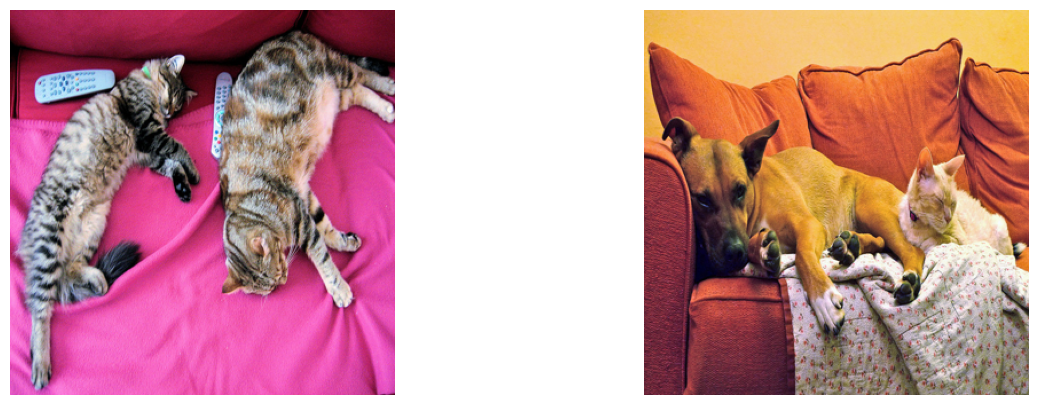

In [4]:
# plot the three images

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(image1)
axs[0].axis("off")
axs[1].imshow(image2)
axs[1].axis("off")
plt.show()


In [5]:

processor = Idefics2Processor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:

model = Idefics2Model.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.bfloat16
).to(DEVICE)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Two dogs lying on a purple blanket next to a tv remote control"},
        ]
    },
]

In [8]:
prompt = processor.apply_chat_template(messages, add_generation_prompt=False)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}



In [9]:

print(inputs["input_ids"][0])
# Get the indices of the image tokens ids 32001
image_token_indices = inputs["input_ids"].eq(32001).nonzero(as_tuple=True)[1]

# get the text token id indices that are between the second id 32000 and the second to last id
text_token_indices = torch.arange(image_token_indices[-1] + 2, inputs["input_ids"].shape[1] - 3).to(DEVICE)

print(image_token_indices)
print(text_token_indices)

tensor([    1,  1247, 28747, 32000, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001,
        32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32000,  6005,
         9540, 10580,   356,   264, 19435, 21434,  1679,   298,   264,  9781,
         9308,  2602, 32002, 28705,    13], device='cuda:0')
tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67], device='cuda:0')
tensor([6

In [10]:
# Decode the text tokens for the text token indices
for i in range(len(text_token_indices)):
    word = processor.decode(inputs["input_ids"][0][text_token_indices[i]])
    print(word)

Two
dogs
lying
on
a
purple
blanket
next
to
a
tv
remote
control


In [11]:
outputs = model(**inputs, output_hidden_states=True)

/home/levi/projects/orbit/_isaac_sim/extscache/omni.pip.torch-2_0_1-2.0.2+105.1.lx64/torch-2-0-1/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
all_embeddings = outputs.last_hidden_state

# get the image embedding indices where the input id is <image>
image_embeddings = all_embeddings[0, image_token_indices]

# get the text embedding indices where the input id is <text>
text_embeddings = all_embeddings[0, text_token_indices]

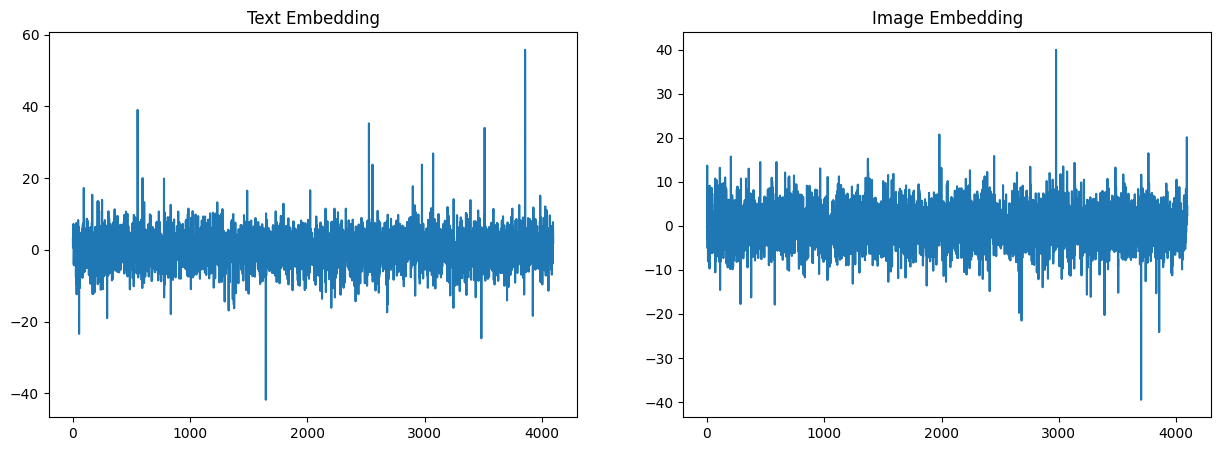

In [13]:
# convert embeddings to float32
text_embeddings_np = text_embeddings.float().detach().cpu().numpy()
image_embeddings_np = image_embeddings.float().detach().cpu().numpy()

# plot the first embedding on a line plot for text and image
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(text_embeddings_np[0, :])
axs[0].set_title("Text Embedding")
axs[1].plot(image_embeddings_np[0, :])
axs[1].set_title("Image Embedding")
plt.show()


In [14]:
# Create a confusion matrix for the cosine similarity between the image embeddings and the text embeddings
# Assuming text_embeddings and image_embeddings are lists of tensors
text_emb = text_embeddings  # Shape: [N, D] where N is the number of text embeddings, D is the dimension
image_emb = image_embeddings  # Shape: [M, D] where M is the number of image embeddings

# Normalize the embeddings to unit vectors
text_emb_normalized = F.normalize(text_emb, p=2, dim=1)
image_emb_normalized = F.normalize(image_emb, p=2, dim=1)

# Compute cosine similarity
cos_sim_matrix = torch.mm(text_emb_normalized, image_emb_normalized.t())  # Shape: [N, M]

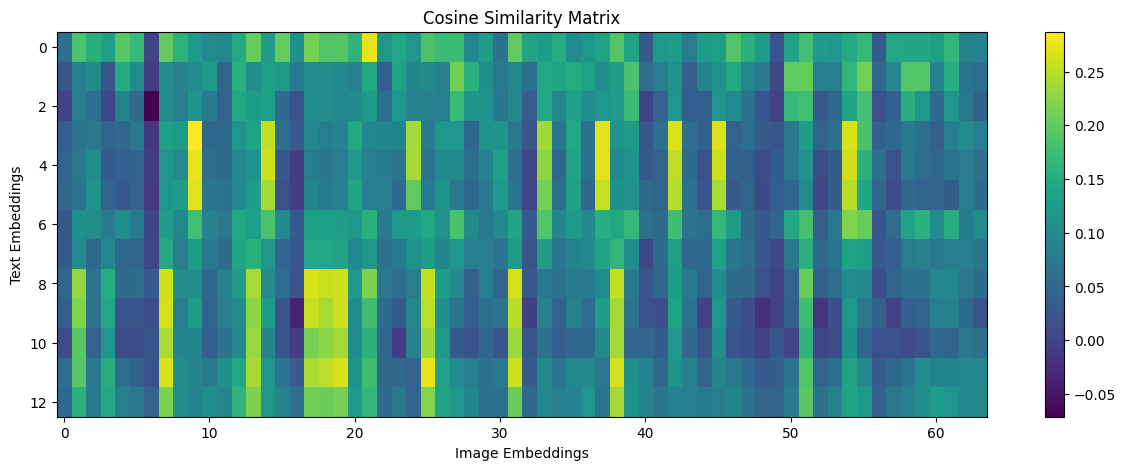

In [15]:
# plot the confusion matrix as a large heatmap
plt.figure(figsize=(15, 5))
plt.imshow(cos_sim_matrix.float().detach().cpu().numpy(), cmap="viridis", aspect="auto")
plt.colorbar()
plt.xlabel("Image Embeddings")
plt.ylabel("Text Embeddings")
plt.title("Cosine Similarity Matrix")
plt.show()

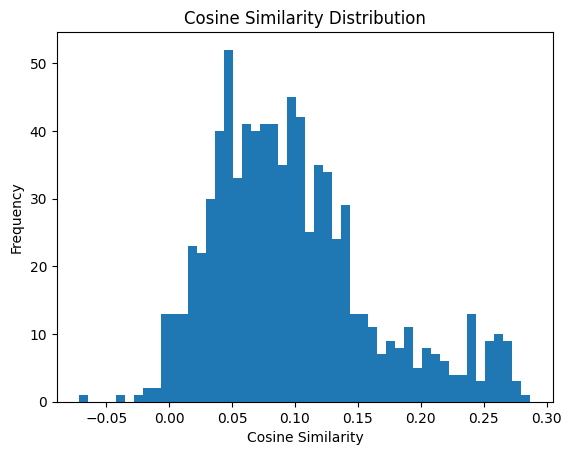

In [16]:
# plot the distribution of the cosine similarity values
plt.hist(cos_sim_matrix.flatten().float().detach().cpu().numpy(), bins=50)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution")
plt.show()

In [17]:
# comput the mean text embedding 
max_text_embedding = text_embeddings.mean(dim=0).unsqueeze(0)

# compute the mean image embedding
max_image_embedding = image_embeddings.mean(dim=0).unsqueeze(0)

# compute the cosine similarity between the average text and image embeddings
average_cos_sim = F.cosine_similarity(max_text_embedding, max_image_embedding)

print(average_cos_sim.item())



0.326171875


In [18]:
# compute the average of the similarity matrix
average_cos_sim_matrix = cos_sim_matrix.flatten().mean()

print(average_cos_sim_matrix.item())

0.09765625


In [19]:
# the below dictionary contains the details of the evaluation dataset

caption_dict = {
    'ApmsZfwwqew': [
        {
        'filepath': '/home/levi/data/dev_videos/CookinWithCarolPoachedSalmoninLemongrassInfusedBrothwithSpinach.mp4',
        'start_frame':1290,
        'end_frame': 1440,
        'caption': 'Add vegetable to the pan'
        },
        {
        'filepath': '/home/levi/data/dev_videos/CookinWithCarolPoachedSalmoninLemongrassInfusedBrothwithSpinach.mp4',
        'start_frame': 1890,
        'end_frame': 1980,
        'caption': 'Add sesame oil to the pan'
        },
        {
        'filepath': '/home/levi/data/dev_videos/CookinWithCarolPoachedSalmoninLemongrassInfusedBrothwithSpinach.mp4',
        'start_frame': 4200,
        'end_frame': 5040,
        'caption': 'Remove the salmon and vegetables from the pan and place them on a serving plate'
        }
    ],
    'jRHls8ekOTE': [
        {
        'filepath': '/home/levi/data/dev_videos/HomemadeKidSafeWoodToyFinishBeeswaxandMineralOilLHP.mp4',
        'start_frame': 3270,
        'end_frame': 3840,
        'caption': 'Use the cheese grater to grate the beeswax'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HomemadeKidSafeWoodToyFinishBeeswaxandMineralOilLHP.mp4',
        'start_frame': 5520,
        'end_frame': 6300,
        'caption': 'Stir the mixture until the beeswax is melted'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HomemadeKidSafeWoodToyFinishBeeswaxandMineralOilLHP.mp4',
        'start_frame': 6810,
        'end_frame': 7200,
        'caption': 'Pour the mixture into a glass jar'
        }
    ],
    'KfnyopxdJXQ': [
        {
        'filepath': '/home/levi/data/dev_videos/HowToMakeaPaperCraneOrigamiCraneStepbyStepEasy.mp4',
        'start_frame': 780,
        'end_frame': 1200,
        'caption': 'Fold the paper across one diagonal'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HowToMakeaPaperCraneOrigamiCraneStepbyStepEasy.mp4',
        'start_frame': 1290,
        'end_frame': 1650,
        'caption': 'Use a pair of scissors to cut off the bottom of the paper'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HowToMakeaPaperCraneOrigamiCraneStepbyStepEasy.mp4',
        'start_frame': 4050,
        'end_frame': 4380,
        'caption': 'Use a pink marker to draw lines along the middle of the paper'
        }
    ],
    '0bbUI5WWq_Y': [
        {
        'filepath': '/home/levi/data/dev_videos/LentilandSpinachSoupCalciumRichbyTarlaDalal.mp4',
        'start_frame': 1624,
        'end_frame': 1724,
        'caption': 'Pour water from the pitcher into the pot with vegetables'
        },
        {
        'filepath': '/home/levi/data/dev_videos/LentilandSpinachSoupCalciumRichbyTarlaDalal.mp4',
        'start_frame': 2898,
        'end_frame': 3000,
        'caption': 'Add chopped spinach to the soup mixture in the pot'
        },
        {
        'filepath': '/home/levi/data/dev_videos/LentilandSpinachSoupCalciumRichbyTarlaDalal.mp4',
        'start_frame': 3300,
        'end_frame': 3650,
        'caption': 'Stir the soup in the pot while it boils'
        }
    ],
    'I9ETbXCSWUg': [
        {
        'filepath': '/home/levi/data/dev_videos/HomeOrganizationStorageOrganizationforanOutdoorRecreationArea.mp4',
        'start_frame': 216,
        'end_frame': 288,
        'caption': 'Place drinks in the cooler'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HomeOrganizationStorageOrganizationforanOutdoorRecreationArea.mp4',
        'start_frame': 504,
        'end_frame': 600,
        'caption': 'Place sports equipment in the storage bin'
        },
        {
        'filepath': '/home/levi/data/dev_videos/HomeOrganizationStorageOrganizationforanOutdoorRecreationArea.mp4',
        'start_frame': 2568,
        'end_frame': 2688,
        'caption': 'Move the rackets from the middle shelf the bottom shelf'
        }
    ]
}



In [20]:
def get_video_frames(video_path: str, num_frames: int =32, start_frame: int=-1, end_frame: int=-1):
    # Load the video
    vr = decord.VideoReader(video_path)
    if start_frame == -1:
        start_frame = 0
    if end_frame == -1:
        end_frame = len(vr)
    segment_frame_count = end_frame - start_frame
    frame_delta = segment_frame_count // num_frames
    # get the first num_frames frame indices from the segment
    frame_idx = [start_frame+i*frame_delta for i in range(num_frames)]
    # if frame_idx has more elements than num_frames, remove the last element
    if len(frame_idx) > num_frames:
        frame_idx = frame_idx[:-1]       
    
    frames = torch.tensor(vr.get_batch(frame_idx).asnumpy(), dtype=torch.float32)
    return frames

In [21]:
# Create a list of video segments with the frames and captions of each video segment
video_segments = []
num_frames = 20
for video_id in caption_dict:
    for segment in caption_dict[video_id]:
        # Extract the frames from the video segment
        frames = get_video_frames(segment['filepath'], num_frames, segment['start_frame'], segment['end_frame'])
       
        video_segments.append({
            'frames': frames,
            'caption': segment['caption']
        })

In [22]:
def compute_videoclip_scores(video_frames, caption, model, processor):

    # Encode the text
    message = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": f"{caption}"},
        ]
        },
    ]   
    prompt = processor.apply_chat_template(message, add_generation_prompt=False)
    model = model.cuda()

    score = 0
    for i, image1 in enumerate(video_frames):
        image1 = Image.fromarray(image1.numpy().astype(np.uint8))
        inputs = processor(text=prompt, images=[image1], return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        all_embeddings = outputs.last_hidden_state

        image_token_indices = inputs["input_ids"].eq(32001).nonzero(as_tuple=True)[1]
        text_token_indices = torch.arange(image_token_indices[-1] + 2, inputs["input_ids"].shape[1] - 3)

        image_embeddings = all_embeddings[0, image_token_indices]
        text_embeddings = all_embeddings[0, text_token_indices]

        # Normalize the embeddings to unit vectors
        text_emb_normalized = F.normalize(text_embeddings, p=2, dim=1)
        image_emb_normalized = F.normalize(image_embeddings, p=2, dim=1)   


        # comput the mean text embedding 
        mean_text_embedding = text_emb_normalized.mean(dim=0).unsqueeze(0)

        # compute the mean image embedding
        mean_image_embedding = image_emb_normalized.mean(dim=0).unsqueeze(0)

        # compute the cosine similarity between the average text and image embeddings
        cos_sim = F.cosine_similarity(mean_text_embedding, mean_image_embedding) 
        # store the max between the old score and the new score
        score += cos_sim.item()
    return score
    

In [51]:
# Create a cofusion matrix of the score for each video segment
confusion_matrix = np.zeros((len(video_segments), len(video_segments)))
for i, segment1 in enumerate(video_segments):
    frames1 = segment1['frames']
    caption1 = segment1['caption']
    print(f"Processing {i}: {caption1}")
    for j, segment2 in enumerate(video_segments):
        # frames2 = segment2['frames']
        # frames2 = preprocess_frames(frames2)
        caption2 = segment2['caption']        
        score = compute_videoclip_scores(frames1, caption2, model, processor)
        confusion_matrix[i, j] = score


Processing 0: Add vegetable to the pan
Processing 1: Add sesame oil to the pan
Processing 2: Remove the salmon and vegetables from the pan and place them on a serving plate
Processing 3: Use the cheese grater to grate the beeswax
Processing 4: Stir the mixture until the beeswax is melted
Processing 5: Pour the mixture into a glass jar
Processing 6: Fold the paper across one diagonal
Processing 7: Use a pair of scissors to cut off the bottom of the paper
Processing 8: Use a pink marker to draw lines along the middle of the paper
Processing 9: Pour water from the pitcher into the pot with vegetables
Processing 10: Add chopped spinach to the soup mixture in the pot
Processing 11: Stir the soup in the pot while it boils
Processing 12: Place drinks in the cooler
Processing 13: Place sports equipment in the storage bin
Processing 14: Move the rackets from the middle shelf the bottom shelf


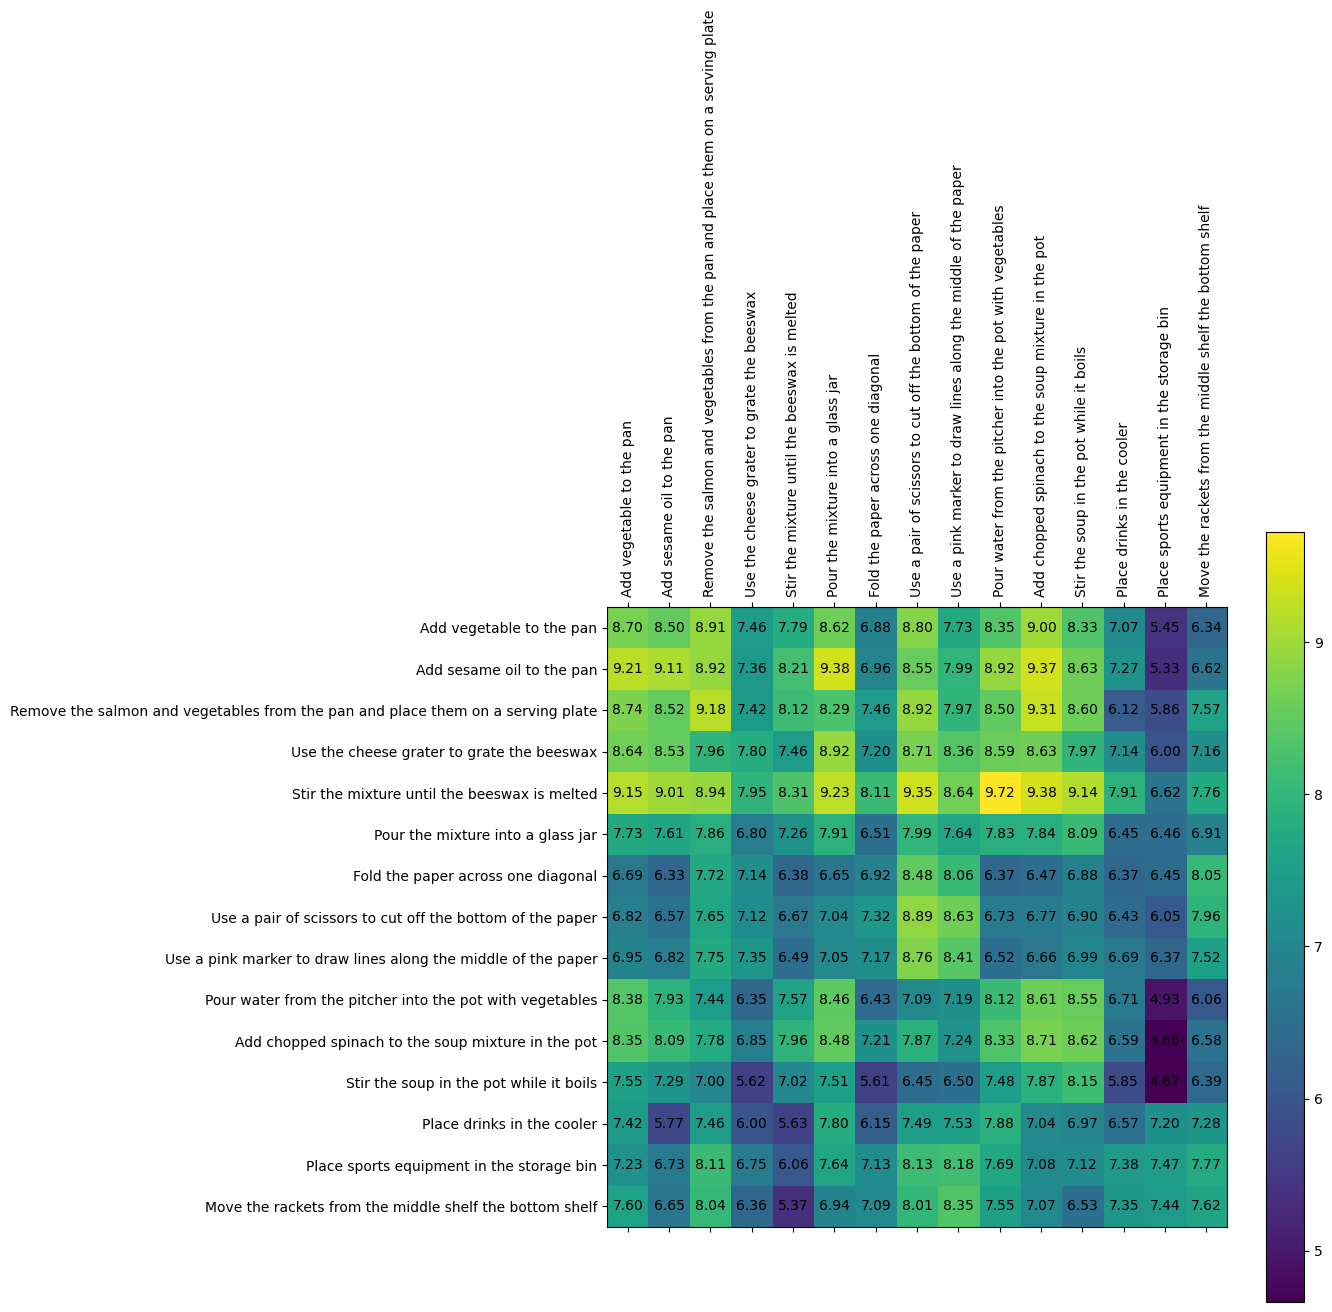

In [52]:
# Plot the confusion matrix

# add values to each square and show the captions on the x axis on the top of the plot
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(confusion_matrix, cmap='viridis')
for i in range(len(video_segments)):
    for j in range(len(video_segments)):
        ax.text(j, i, f'{confusion_matrix[i, j]:.2f}', ha='center', va='center', color='black')
ax.set_xticks(range(len(video_segments)))
ax.set_xticklabels([segment['caption'] for segment in video_segments], rotation=90)
ax.set_yticks(range(len(video_segments)))
ax.set_yticklabels([segment['caption'] for segment in video_segments])
plt.colorbar(cax)
plt.show()


In [53]:
# Compute the number of correct predictions
correct_predictions = 0
for i in range(len(video_segments)):
    if np.argmax(confusion_matrix[i]) == i:
        correct_predictions += 1

accuracy = correct_predictions / len(video_segments)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.20


Frame 0: Use a pink marker to draw lines along the middle of the paper - Score: 0.42578125


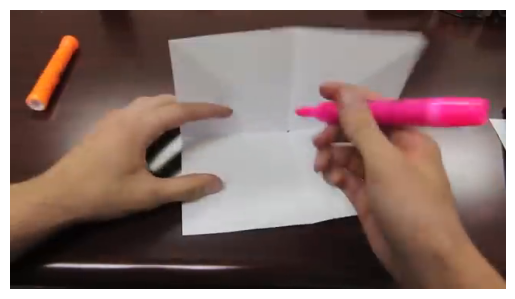

Frame 1: Use a pink marker to draw lines along the middle of the paper - Score: 0.4140625


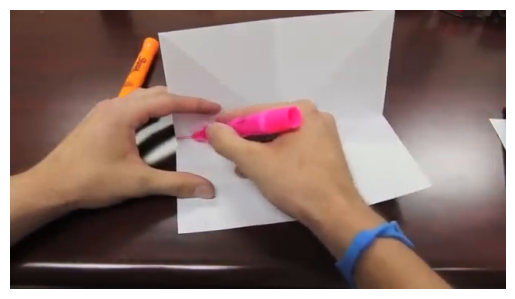

Frame 2: Use a pink marker to draw lines along the middle of the paper - Score: 0.4453125


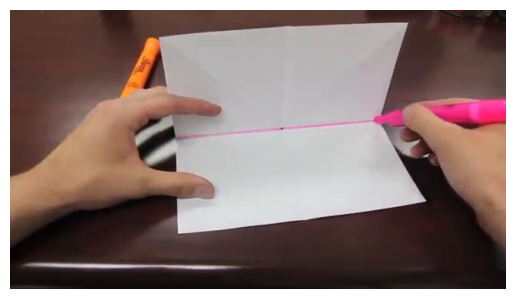

Frame 3: Use a pink marker to draw lines along the middle of the paper - Score: 0.41015625


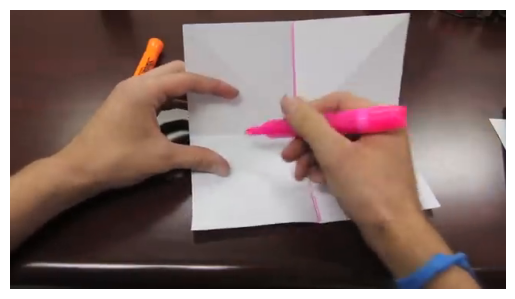

Frame 4: Use a pink marker to draw lines along the middle of the paper - Score: 0.419921875


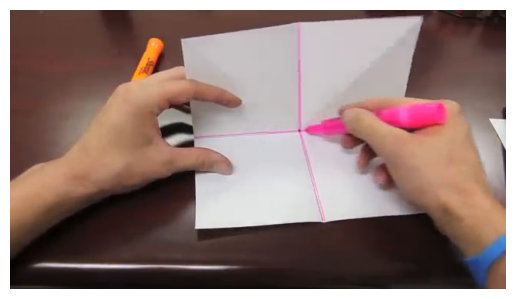

In [35]:
# for each frame in a video segment, compute the cosine similarity between the text and image embeddings and display the text, plot the image and display the resulting score
def display_video_clip(video_frames, caption, model, processor):
    message = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": f"{caption}"},
        ]
        },
    ]   
    prompt = processor.apply_chat_template(message, add_generation_prompt=False)
    model = model.cuda()

    for i, image1 in enumerate(video_frames):
        image1 = Image.fromarray(image1.numpy().astype(np.uint8))
        inputs = processor(text=prompt, images=[image1], return_tensors="pt")
        inputs = {k: v.cuda() for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        all_embeddings = outputs.last_hidden_state

        image_token_indices = inputs["input_ids"].eq(32001).nonzero(as_tuple=True)[1]
        text_token_indices = torch.arange(image_token_indices[-1] + 2, inputs["input_ids"].shape[1] - 3)

        image_embeddings = all_embeddings[0, image_token_indices]
        text_embeddings = all_embeddings[0, text_token_indices]

        # comput the mean text embedding 
        mean_text_embedding = text_embeddings.mean(dim=0).unsqueeze(0)

        # compute the mean image embedding
        mean_image_embedding = image_embeddings.mean(dim=0).unsqueeze(0)

        # compute the cosine similarity between the average text and image embeddings
        score = F.cosine_similarity(mean_text_embedding, mean_image_embedding) 
        print(f"Frame {i}: {caption} - Score: {score.item()}")
        plt.imshow(image1)
        plt.axis("off")
        plt.show()

# Display the video clip for the first video segment
seg_idx = 8
display_video_clip(video_segments[seg_idx]['frames'], video_segments[seg_idx]['caption'], model, processor)

In [23]:
# Get the robot manipulation video and create a set of descriptive captions for the video
robot_manipulation_video_path = '/home/levi/data/dev_videos/video_3.mp4'

# get frames from the video
frames = get_video_frames(robot_manipulation_video_path, num_frames=num_frames)


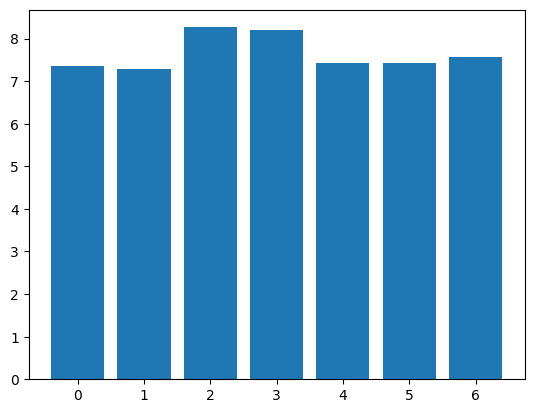

In [25]:


# Create captions for the video
captions = [
    'The robot picks up the object',  
    'The robot picks up the cube',
    'The robot arm picks up the cube',
    'The panda gripper picks up the cube'
    'The panda gripper picks up the cube and moves it to the colored location',
    'The panda gripper reaches for the cube, picks it up and moves it to the colored location',
    'The panda gripper reaches for the cube, grasps the cube, picks it up and moves it to the colored location',
    'The panda gripper reaches for the cube, grasps the cube, raises the cube into the air, moves the cube to the colored location and places the cube on the colored location',
    'The panda gripper reaches for the cube, grasps the cube, raises the cube into the air, moves the cube to the colored cooridnates and places the cube on the colored coordinates'   
]

captions = [
    'Pick up the object',  
    'Pick up the cube',
    'Pick up the cube and move it to the colored location',
    'Reach for the cube, pick it up and move it to the colored location',
    'Reach for the cube, grasp the cube, pick it up and lift it to the colored location',
    'Reach for the cube, grasp the cube, raise the cube into the air, lift the cube to the colored location',
    'Reach for the cube, grasp the cube, raise the cube into the air, move the cube to the colored cooridnates and place the cube on the colored coordinates'   
]


scores = []
for caption in captions:
    score = compute_videoclip_scores(frames, caption, model, processor)
    score = float(score)
    scores.append(score)

# convert scores to array of floats
scores = np.array(scores).astype(float)

# plot the height of each score on a bar chart with the caption index on the x-axis
fig, ax = plt.subplots()
ax.bar(range(len(captions)), scores)
ax.set_xticks(range(len(captions)))
ax.set_xticklabels(range(len(captions)))
plt.show()

    

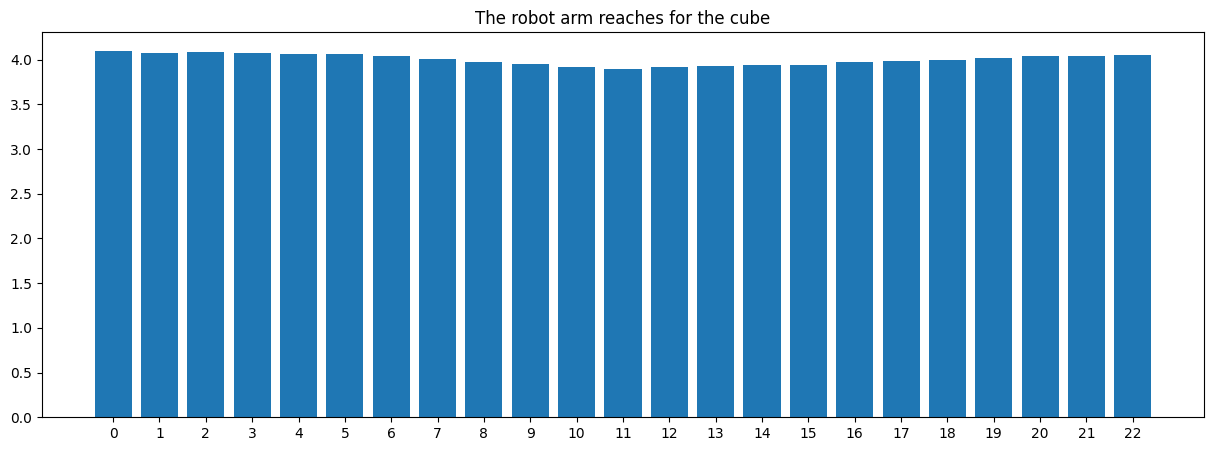

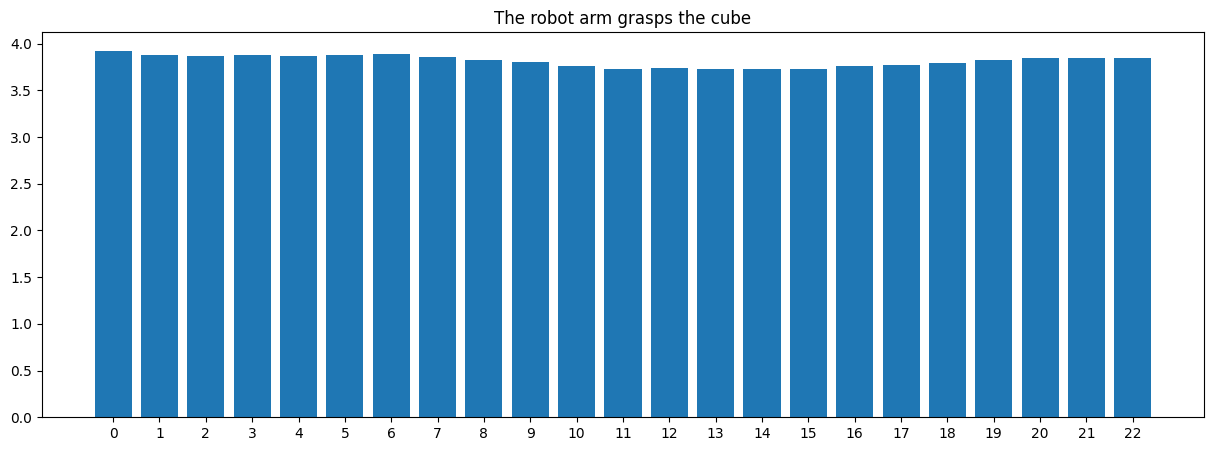

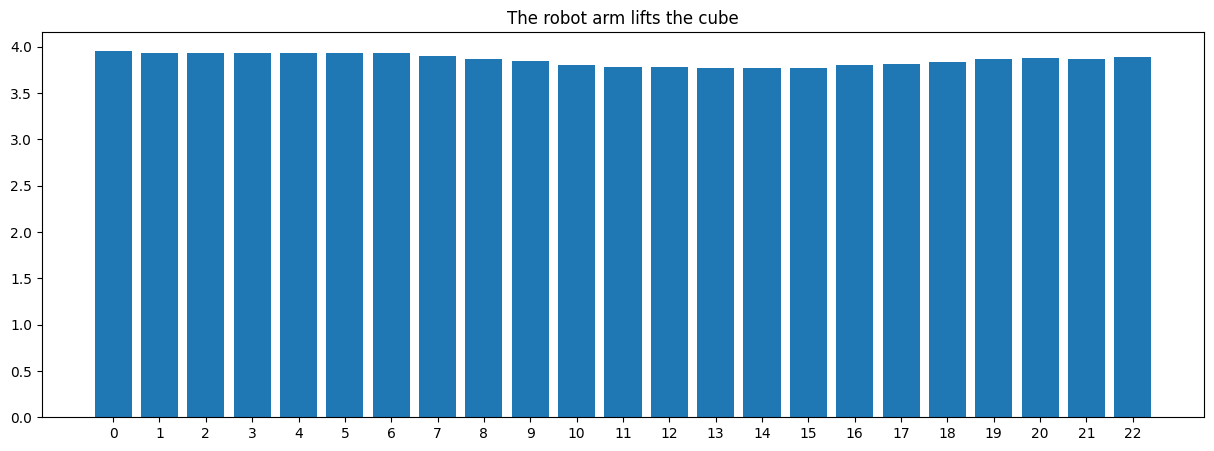

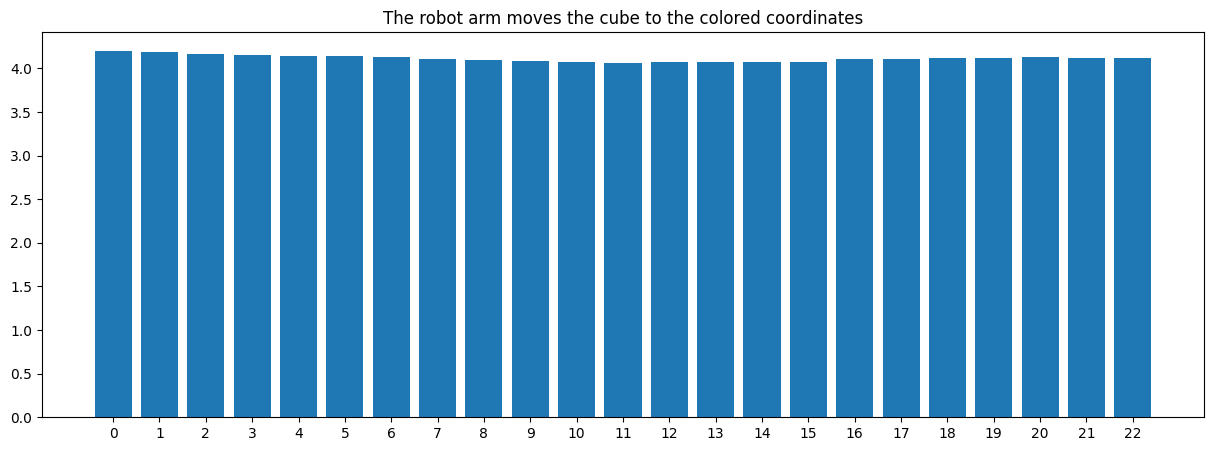

In [27]:
robot_manipulation_video_path = '/home/levi/data/dev_videos/video_3.mp4'

video_frame_len = 250

num_frames = 10
segment_length = 10
segment_gap = 2


captions = [
    'Reach for the cube',
    'Grab the cube',
    'Pick up the cube',
    'Move the cube to the colored coordinates',
]
captions = [
    'The robot arm reaches for the cube',
    'The robot arm grasps the cube',
    'The robot arm lifts the cube',
    'The robot arm moves the cube to the colored coordinates',
]
# for every 5 frames, grab 30 frames at a time and get the scores for each caption

for caption in captions:
    scores = []
    for i in range(4, 60-segment_length, segment_gap):
        frames = get_video_frames(robot_manipulation_video_path, num_frames=num_frames, start_frame=i, end_frame=i+segment_length)
        # plot each frame in the segment to see what the robot is doing
        if 0:
            plt.figure(figsize=(16, 40))
            for i in range(num_frames):
                plt.subplot(1, num_frames, i + 1)
                plt.imshow(frames[i].cpu().numpy().astype(int))
                plt.axis('off')
            plt.show()
        score = compute_videoclip_scores(frames, caption, model, processor)
        score = float(score)
        scores.append(score)
    scores = np.array(scores).astype(float)

    # plot the height of each score on a bar chart with the caption index on the x-axis
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(range(len(scores)), scores)
    ax.set_xticks(range(len(scores)))
    ax.set_xticklabels(range(len(scores)))
    plt.title(caption)
    plt.show()